In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle

In [2]:
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [3]:
path = os.path.join("..", "data", "cluster_df.pickle")
with open(path, "rb") as archivo:
    cluster_df = pickle.load(archivo).T

In [4]:
tags_animes = pd.read_csv(os.path.join("..", "data", "unified_df.csv"))
tags_animes["Tags"] = tags_animes["Tags"].fillna("")
tags_animes["Tags"] = tags_animes["Tags"].apply(
    lambda x: [x.strip("'") for x in x.lstrip("[").rstrip("]").split(", ")]
)
tags_animes

,Anime,URL,Tags,Alts,id
0,"Chiaki Kuriyama: ""0""",https://www.anime-planet.com/anime/chiaki-kuri...,[],NaN,20707
1,"""Bungaku Shoujo"" Kyou no Oyatsu: Hatsukoi",https://www.anime-planet.com/anime/bungaku-sho...,"[Romance, Library, School Life, Based on a Lig...",NaN,7669
2,"""Bungaku Shoujo"" Memoire",https://www.anime-planet.com/anime/bungaku-sho...,"[Drama, Romance, Episodic, School Life, Based ...",NaN,8481
3,"""Bungaku Shoujo"" Movie",https://www.anime-planet.com/anime/bungaku-sho...,"[Drama, Mystery, Romance, School Club, School ...",NaN,6408
4,"""Eiji""",https://www.anime-planet.com/anime/eiji,"[Shounen, Sports, Boxing, Hand to Hand Combat,...",NaN,6076
...,...,...,...,...,...
8767,Crystal Sky of Yesterday,https://www.anime-planet.com/anime/crystal-sky...,"[Drama, Romance, Chinese Animation, Coming of ...",\r\nAlt title: Zuori Qing Kong\r\n,37207
8768,Meychan: Zurui Maboroshi,https://www.anime-planet.com/anime/meychan-zur...,[],NaN,52512
8769,I've Always Liked You,https://www.anime-planet.com/anime/ive-always-...,"[Drama, Romance, Based on a Song, Childhood Fr...",\r\nAlt title: Zutto Mae Kara Suki deshita. Ko...,31245
8770,I've Always Liked You Special,https://www.anime-planet.com/anime/ive-always-...,"[Romance, Based on a Song, Love Confession, Sc...",\r\nAlt title: Zutto Mae Kara Suki deshita: Ko...,36305


In [5]:
cluster_df = cluster_df.astype(pd.SparseDtype(np.float64, fill_value=0))

# Exploracion inicial

## Preparar matriz

In [140]:
cluster_df = cluster_df[cluster_df.sum(axis=1) > 0] # Muy importante, para no dividir por 0

# El porque algunos tienen 0, es o porque el anime que vieron no tenia tags, o habian visto algun anime que no sobrevivio la union MyAnimeList - AnimePlanet.
# Recuerden que si quieren ver el proceso de union, vean procesar_data.ipynb

In [5]:
# Hacer que todas las filas sumen 1
cluster_df_normal = cluster_df.sparse.to_dense()
cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)

# No, yo tampoco sabia esto, y si, fue hecho por copilot.
# Dataframe.div basicamente divide cada serie de una axis de un dataframe, por una serie con los mismos indices de la axis.
# En este caso, se usa la axis de la fila (axis=0), y se divide por la serie de sumas de filas
# Y eso hace que todo sume 1.

In [6]:
matriz = cluster_df_normal.to_numpy()
matriz

## Numero de componentes

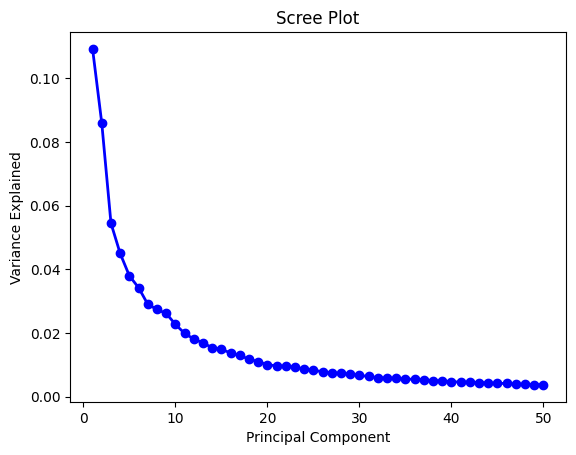

In [8]:
pca = PCA(n_components=200)
pca.fit(matriz)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(range(1,50 + 1), pca.explained_variance_ratio_[0:50], 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

El metodo del codo diria que tenemos que usar aproximadamente 7 componentes

## KMeans

In [ ]:
from sklearn.cluster import KMeans

inertia = []
kmax = 100

# entrenamiento y evaluación
for i in range(1,kmax + 1):
    # modelo
    kmeans = KMeans(n_clusters=i, n_init='auto')
    nCluster = kmeans.fit(X)

    print(i, nCluster.inertia_)
    inertia.append(nCluster.inertia_)

1 53.466351960263964
2 45.40456001292926
3 40.183821885754995
4 37.260434679944055
5 35.05497206335995
6 32.310047433888926
7 30.79212428571468
8 29.247162452008695
9 27.759907518815034
10 26.205948094758693
11 25.215684856536512
12 24.746063613886204
13 23.6317035096461
14 22.987601308616593
15 22.41166629931857
16 21.94205450668102
17 21.21136499956556
18 20.73551830246631
19 20.756369793619825
20 19.89611725209814
21 19.93636089524315
22 19.671126293865722
23 18.982532705853345
24 18.670679768832795
25 18.17079320497028
26 17.965090980977564
27 17.736311830097215
28 17.412510651308562
29 17.31788326280766
30 17.054811673253425
31 16.86063904519769
32 16.54891312914029
33 16.311112851300816
34 16.00979612884208
35 15.925835886216433
36 15.960424798572264
37 15.64056327226016
38 15.445563041631406
39 15.382603687398586
40 15.291534772503372
41 14.974696191985707
42 15.061723384942518
43 14.64980590911313
44 14.614390473821555
45 14.338930499733948
46 14.30671513539453
47 14.1473350312

Text(0.5, 1.0, 'K-means - Método del codo')

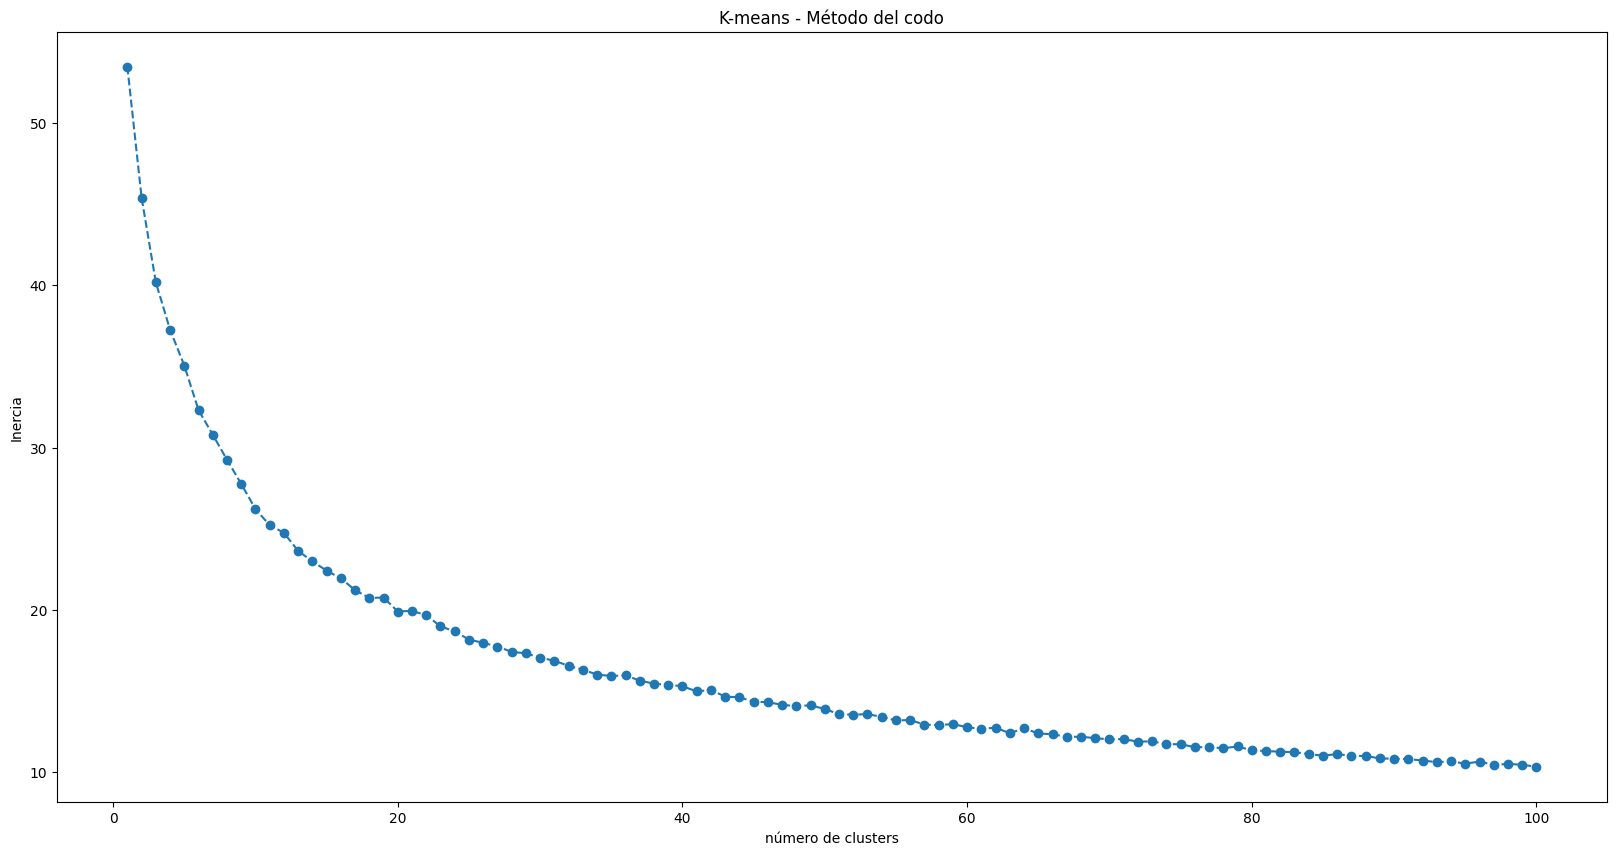

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(20,10))

ax.plot(range(1, kmax + 1), inertia, marker='o', ls='--')
ax.set_xlabel('número de clusters')
ax.set_ylabel('Inercia')
ax.set_title('K-means - Método del codo')

Por metodo del codo unos 20 clusters tiene sentido

# Iteracion Rapida

Como no estamos seguros de que tan bueno es un modelo, va a ser neccesario iterar mediante varios modelos con distintos metodos, ya sea en normalizacion de datos, u otra cosa para poder encontrar el mejor modelo para agrupar los usuarios.

Para lograr eso, vamos a abstraer ciertas funciones, para poder hacer el proceso mas rapido

## Definir metodos

In [8]:
def to_df(matriz, grupos, indexes, columns):
    df = pd.DataFrame(matriz, index=indexes, columns=columns)
    df["grupo"] = grupos
    return df

def gustos_anime(df, grupo, cantidad):
    df_copy = df.copy()
    df_copy["grupo"] = grupo
    agrupado = df_copy.groupby("grupo").mean()
    for index, grupo in agrupado.iterrows():
        print(f"{index}:\n{grupo.sort_values(ascending=False).head(cantidad)}\n")

def eficiencia(data, grupos):
    print(f"Silhouette score, mas cercano a 1 es mejor: {silhouette_score(data, grupos)}")
    print(f"Davies Bouldin score, mas cercano a 0 es mejor: {davies_bouldin_score(data, grupos)}")
    print(f"Calinski Harabasz score, mayor es mejor: {calinski_harabasz_score(data, grupos)}")

def plot_pca(df, x, y, z, c):
    plt.close()
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111, projection='3d')

    Xax = df[x]
    Yax = df[y]
    Zax = df[z]
    Gax = df[c]

    norm=plt.Normalize(Gax.min(), Gax.max()) # El rango de valores para el colormap

    for l in sorted(Gax.unique()):
        ix = Gax == l
        ax.scatter(Xax[ix], Yax[ix], Zax[ix], cmap="gist_ncar", norm=norm, c=Gax[ix], alpha=1, s=12, label=l)

    ax.set_xlabel(x, fontsize=12)
    ax.set_ylabel(y, fontsize=12)
    ax.set_zlabel(z, fontsize=12)
    
    ax.view_init(30, 125)
    ax.legend()
    plt.title("3D PCA plot")
    plt.show()

## Iteracion 1.

Normalizacion a distancia 1 de las filas

La matriz se estandariza para una distribucion estandar de 1 y un promedio 0

**Esto fue algo encontrado en otras iteraciones, pero se eliminan las columnas "Based on a Manga", "Original Work", "Based on a Light Novel", pues estas causaban cierto nivel de ruido en el analisis, y no aportan mucho, pues no representan gusto, si no que procedencia del contenido**

In [22]:
cluster_df_normal = cluster_df.copy()

cluster_df_normal = cluster_df_normal.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"])
cluster_df_normal = cluster_df_normal[cluster_df.sum(axis=1) > 0]
cluster_df_normal = cluster_df_normal.sparse.to_dense()
# Normalizar suma a 1
# cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)
# Normalizar norma a 1
cluster_df_normal = cluster_df_normal.div((cluster_df_normal.iloc[0,] ** 2).sum()**0.5, axis=0)
matriz = cluster_df_normal.to_numpy()

matriz = StandardScaler().fit_transform(matriz)

In [23]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)

pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()

Respecto a PCA
Silhouette score, mas cercano a 1 es mejor: 0.48267962400595854
Davies Bouldin score, mas cercano a 0 es mejor: 1.0857995939100848
Calinski Harabasz score, mayor es mejor: 5206.855709901671

Respecto a df
Silhouette score, mas cercano a 1 es mejor: 0.38099126150197554
Davies Bouldin score, mas cercano a 0 es mejor: 2.338084056377684
Calinski Harabasz score, mayor es mejor: 3718.50187976753



0:
Action           0.099879
Shounen          0.085148
Drama            0.068369
Fantasy          0.061440
Comedy           0.059845
School Life      0.047695
Mature Themes    0.045963
Violence         0.045567
Supernatural     0.042762
Romance          0.037282
Name: 0, dtype: float64

1:
Comedy          1.500695
Action          1.266519
Drama           1.139872
School Life     1.047556
Shounen         1.040209
Romance         0.974104
Fantasy         0.927090
Supernatural    0.672685
Sci Fi          0.623768
Violence        0.562562
Name: 1, dtype: float64

2:
Action          3.985965
Comedy          3.663749
Shounen         2.936426
Fantasy         2.866495
Drama           2.487991
School Life     2.444335
Romance         2.223705
Violence        1.699529
Supernatural    1.502749
Adventure       1.475994
Name: 2, dtype: float64

3:
Action          2.402677
Comedy          1.883417
Fantasy         1.669039
Shounen         1.663316
Drama           1.448520
School Life     1.322741
Rom

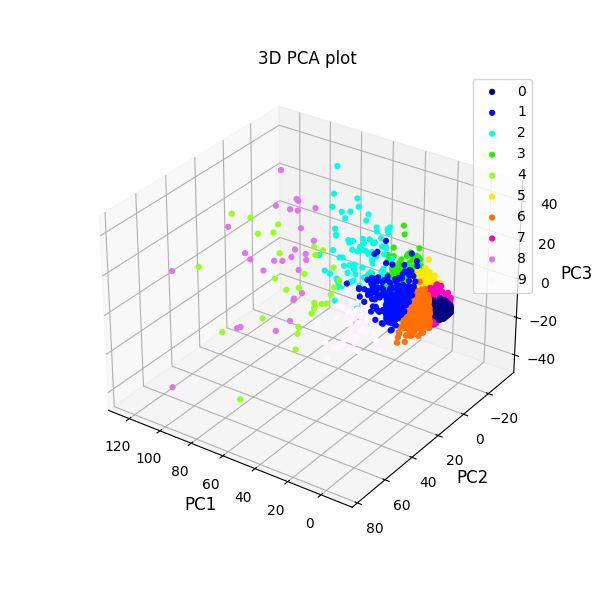

In [13]:
X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

## iteracion 2

Normalizacion a distancia 1 de las filas

La matriz no se estandariza.

In [24]:
cluster_df_normal = cluster_df.copy()

cluster_df_normal = cluster_df_normal.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"])
cluster_df_normal = cluster_df_normal[cluster_df.sum(axis=1) > 0]
cluster_df_normal = cluster_df_normal.sparse.to_dense()
# Normalizar suma a 1
# cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)
# Normalizar norma a 1
cluster_df_normal = cluster_df_normal.div((cluster_df_normal.iloc[0,] ** 2).sum()**0.5, axis=0)
matriz = cluster_df_normal.to_numpy()

Respecto a PCA
Silhouette score, mas cercano a 1 es mejor: 0.4810497289606795
Davies Bouldin score, mas cercano a 0 es mejor: 1.0096422055590861
Calinski Harabasz score, mayor es mejor: 10767.677597017124

Respecto a df
Silhouette score, mas cercano a 1 es mejor: 0.3506675058058132
Davies Bouldin score, mas cercano a 0 es mejor: 1.5703474385351617
Calinski Harabasz score, mayor es mejor: 4850.713074510047

0:
Action           0.071269
Shounen          0.060768
Drama            0.051345
Fantasy          0.045101
Comedy           0.041746
Mature Themes    0.035802
School Life      0.034515
Violence         0.033524
Supernatural     0.032123
Romance          0.027508
Name: 0, dtype: float64

1:
Comedy          2.276640
Action          2.240772
Shounen         1.680517
Drama           1.666841
School Life     1.637102
Fantasy         1.610395
Romance         1.481581
Violence        1.000215
Supernatural    0.972024
Sci Fi          0.918071
Name: 1, dtype: float64

2:
Action          3.637

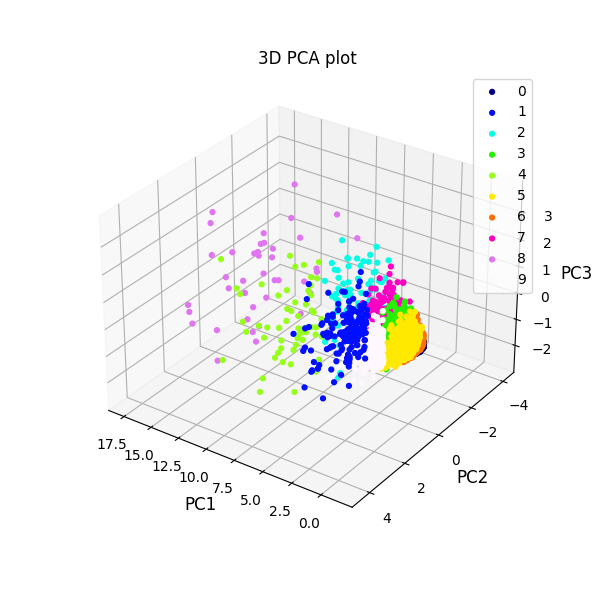

In [25]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)

pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()
X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

## iteracion 3

Suma normal es 1, sin estandarizar

In [6]:
cluster_df_normal = cluster_df.copy()

cluster_df_normal = cluster_df_normal.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"])
cluster_df_normal = cluster_df_normal[cluster_df.sum(axis=1) > 0]
cluster_df_normal = cluster_df_normal.sparse.to_dense()

# Normalizar suma a 1
cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)
matriz = cluster_df_normal.to_numpy()

Respecto a PCA
Silhouette score, mas cercano a 1 es mejor: 0.23174963419509892
Davies Bouldin score, mas cercano a 0 es mejor: 1.11835492815261
Calinski Harabasz score, mayor es mejor: 1928.8619166867666

Respecto a df
Silhouette score, mas cercano a 1 es mejor: -0.024933456199059126
Davies Bouldin score, mas cercano a 0 es mejor: 3.298089739353434
Calinski Harabasz score, mayor es mejor: 188.34062679273012
0:
Action                         0.066076
Shounen                        0.043572
Fantasy                        0.035430
Mature Themes                  0.031592
Explicit Violence              0.029199
Drama                          0.027782
Violence                       0.027648
Sci Fi                         0.022671
Supernatural                   0.021273
Overpowered Main Characters    0.020507
Name: 0, dtype: float64

1:
Comedy          0.059694
School Life     0.042611
Romance         0.039336
Action          0.035703
Shounen         0.033893
Fantasy         0.033124
Drama   

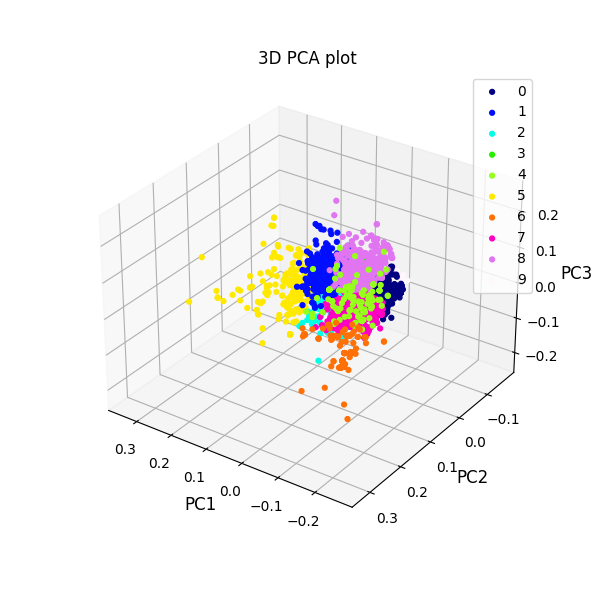

In [28]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()

X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

## iteracion 4

En esta vamos a saltar la reduccion de dimensionalidad y simplemente predecir respecto a la matriz.

Se mantendra la matriz de iteracion 3

La reduccion de dimensionalidad sigue haciendose, pero solo para visualizar

Respecto a PCA
Silhouette score, mas cercano a 1 es mejor: 0.17126040021097053
Davies Bouldin score, mas cercano a 0 es mejor: 1.381973173316578
Calinski Harabasz score, mayor es mejor: 1268.3641673016339

Respecto a df
Silhouette score, mas cercano a 1 es mejor: 0.03191789662208028
Davies Bouldin score, mas cercano a 0 es mejor: 2.4297855757185056
Calinski Harabasz score, mayor es mejor: 213.2631535756465

0:
Action               0.070630
Shounen              0.065835
Fantasy              0.060628
Military             0.049695
Explicit Violence    0.041291
Mature Themes        0.040884
Dark Fantasy         0.037939
Horror               0.036221
Drama                0.033358
Outside World        0.030579
Name: 0, dtype: float64

1:
Romance            0.105857
School Life        0.091467
Drama              0.083106
Comedy             0.082887
Shounen            0.029736
Seinen             0.024965
Supernatural       0.022015
School Club        0.021768
Romantic Comedy    0.020386
Slice 

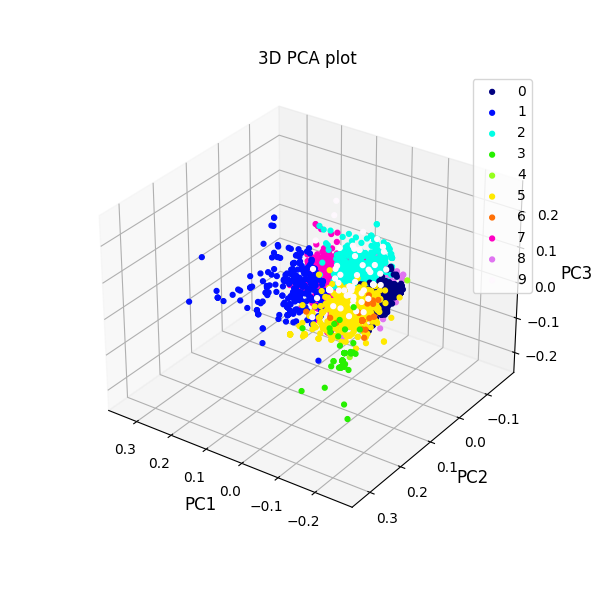

In [30]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(matriz)
G = kmeans.predict(matriz)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()

X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

## iteracion 5

muchos componenetes y grupos, agrupar respecto a PCA

Respecto a PCA
Silhouette score, mas cercano a 1 es mejor: 0.11197046849453876
Davies Bouldin score, mas cercano a 0 es mejor: 1.421467780753857
Calinski Harabasz score, mayor es mejor: 717.9605735711741

Respecto a df
Silhouette score, mas cercano a 1 es mejor: -0.03559626847817891
Davies Bouldin score, mas cercano a 0 es mejor: 2.8115983936106024
Calinski Harabasz score, mayor es mejor: 158.01963390620259

0:
Action          0.094287
Shounen         0.088948
Supernatural    0.040368
Violence        0.032372
Superpowers     0.032203
Adventure       0.031311
Fantasy         0.031251
Drama           0.029876
Comedy          0.025563
Martial Arts    0.021891
Name: 0, dtype: float64

1:
Action           0.045903
Drama            0.038052
Comedy           0.035810
Shounen          0.032583
Fantasy          0.029288
School Life      0.028054
Romance          0.024909
Violence         0.023023
Supernatural     0.022681
Mature Themes    0.021838
Name: 1, dtype: float64

2:
Drama            0.

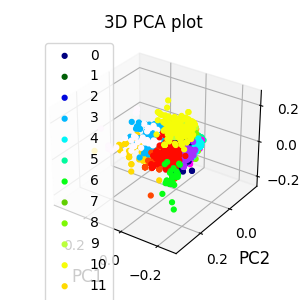

In [9]:
componentes = 7
grupos = 20

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()

X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

## Iteracion 6.

Muchos grupos, sin tomar componentes en cuenta.

Respecto a PCA
Silhouette score, mas cercano a 1 es mejor: 0.08261049075475509
Davies Bouldin score, mas cercano a 0 es mejor: 1.9471512432297868
Calinski Harabasz score, mayor es mejor: 785.6709685668186

Respecto a df
Silhouette score, mas cercano a 1 es mejor: 0.008257928049428345
Davies Bouldin score, mas cercano a 0 es mejor: 2.0619608534332325
Calinski Harabasz score, mayor es mejor: 167.9613785675697

0:
Action                 0.139274
Shounen                0.138915
Ninja                  0.132976
Drama                  0.116598
Revenge                0.113778
Rivalries              0.068201
Orphans                0.068201
Japanese Mythology     0.068201
Fantasy                0.049147
Hand to Hand Combat    0.046734
Name: 0, dtype: float64

1:
Comedy           0.072336
School Life      0.049559
Romance          0.038634
Shounen          0.037588
Action           0.030962
Drama            0.030412
Fantasy          0.026129
Slice of Life    0.023544
Seinen           0.023323
Ecc

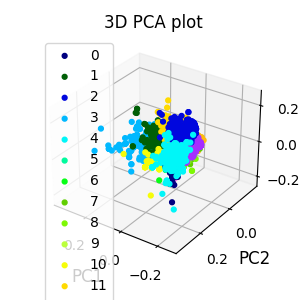

In [35]:
componentes = 3
grupos = 20

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(matriz)
G = kmeans.predict(matriz)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()

X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

## Iteracion 7

Usando KernelPCA, este usa mas dimensiones para poder extraer informacion oculta.

Respecto a PCA
Silhouette score, mas cercano a 1 es mejor: 0.28954175148263483
Davies Bouldin score, mas cercano a 0 es mejor: 0.9814919210825455
Calinski Harabasz score, mayor es mejor: 3766.819824169496

Respecto a df
Silhouette score, mas cercano a 1 es mejor: -0.08474801338527156
Davies Bouldin score, mas cercano a 0 es mejor: 7.789355136408585
Calinski Harabasz score, mayor es mejor: 51.272568683044184

0:
Action           0.052899
Shounen          0.041577
Drama            0.037260
Comedy           0.029480
Fantasy          0.029230
Violence         0.027119
Sci Fi           0.023807
Mature Themes    0.023774
School Life      0.022584
Supernatural     0.021431
Name: 0, dtype: float64

1:
Action          0.076085
Shounen         0.053334
Fantasy         0.036926
Drama           0.036906
Comedy          0.035984
Violence        0.035369
Adventure       0.033222
Supernatural    0.023868
Sci Fi          0.022160
Superpowers     0.020823
Name: 1, dtype: float64

2:
Comedy           0.

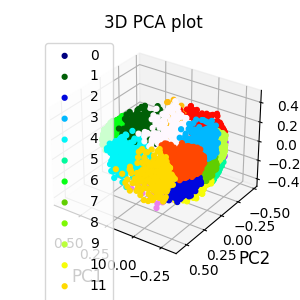

In [39]:
componentes = 3
grupos = 20

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=30)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()

X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

# Iteracion 8

Respecto a PCA
Silhouette score, mas cercano a 1 es mejor: 0.05263901372873336
Davies Bouldin score, mas cercano a 0 es mejor: 3.0491329295163645
Calinski Harabasz score, mayor es mejor: 514.5894316833138

Respecto a df
Silhouette score, mas cercano a 1 es mejor: 0.03536200527201388
Davies Bouldin score, mas cercano a 0 es mejor: 2.1992135763764864
Calinski Harabasz score, mayor es mejor: 163.22332036865993

0:
Action           0.070484
Drama            0.067897
Shounen          0.067662
Violence         0.066725
Fantasy          0.064224
Adventure        0.061501
Mature Themes    0.061072
Military         0.057513
Conspiracy       0.057503
Mystery          0.057390
Name: 0, dtype: float64

1:
Action               0.061379
Shounen              0.044955
Fantasy              0.031819
Drama                0.031800
Mature Themes        0.027419
Violence             0.027366
Supernatural         0.025059
Comedy               0.024228
Explicit Violence    0.022862
Adventure            0.0204

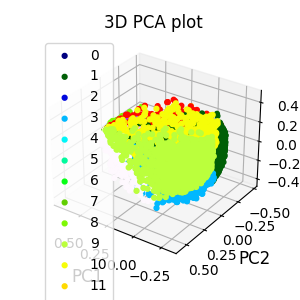

In [87]:
componentes = 3
grupos = 20

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=30)
pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(matriz)
G = kmeans.predict(matriz)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()

X_df = to_df(X, G, indexes=cluster_df_normal.index, columns=[f"PC{i}" for i in range(1, componentes + 1)])
gustos_anime(cluster_df_normal, G, 10)

%matplotlib widget
plot_pca(X_df, "PC1", "PC2", "PC3", "grupo")

In [ ]:
componentes = 3
grupos = 10

# Hacer reduccion de dimensionalidad
# pca = KernelPCA(n_components=componentes, kernel='rbf', gamma=0.1)
pca = PCA(n_components=componentes)

pca.fit(matriz)
X = pca.transform(matriz)

# Hacer clustering
kmeans = KMeans(n_clusters=grupos, n_init='auto')
kmeans.fit(X)
G = kmeans.predict(X)

print("Respecto a PCA")
eficiencia(X, G)
print("\nRespecto a df")
eficiencia(cluster_df_normal, G)

print()

Es dificil sacar conclusiones, incluso haciendo una iteracion con muchos modelos, pues aunque la puntuacion sea buena, eso no significa que el modelo sea bueno o representativo, o en otras palabras, no seria capaz de hacer grupos significantes dentro de la comunidad de anime.

Por ejemplo, el normalizar la informacion respecto a su promedio y desviacion estandar en otros casos puede estar bien, pero en este caso eso puede cambiar el gusto de alguien, lo cual haria el modelo malo para predecir la informacion real, tambien esos modelos funcionaran mejor tomando en cuenta el dataframe normalizado, y quiza no el dataframe real.

Asi que, ¿cual elegir?

Obviamente eso es una pregunta altamente complicada, tan complicada que probablemente sea el campo de estudio para muchos doctorados, magisters, y PHD's

Pero segun lo que se vio en el exploratorio de este archivo, el metodo del codo sugiere unos 7 componentes, con unos 20 grupos. Eso significaria que la mejor iteración seria la 5, mas aun porque esta tiene un formato que puede ser mas acorde a lo que buscamos, hacer que la suma de generos sea 1, o sea que cada numero en los generos es el porcentaje de gusto en ese genero.

Aun asi, deberia ser posible hacer otras clases de modelo para esto, algunos probablemente mejores, pero este deberia ser suficiente para hacer un trabajo moderadamente aceptable.

# Encontrar los animes arquetipos de cada grupo

In [10]:
def generos_favoritos(df, grupo, cantidad):
    df_copy = df.copy()
    df_copy["grupo"] = grupo
    agrupado = df_copy.groupby("grupo").mean()
    grupos_generos = []
    for index, grupo in agrupado.iterrows():
        grupos_generos.append(list(grupo.sort_values(ascending=False).head(cantidad).index))
    return grupos_generos

In [ ]:
buscar = generos_favoritos(cluster_df_normal, G, 10)[3]

In [13]:
generos_favoritos(cluster_df_normal, G, 15)

[['Action',
  'Shounen',
  'Supernatural',
  'Violence',
  'Superpowers',
  'Adventure',
  'Fantasy',
  'Drama',
  'Comedy',
  'Martial Arts',
  'Hand to Hand Combat',
  'Mature Themes',
  'Explicit Violence',
  'Demons',
  'Swordplay'],
 ['Action',
  'Drama',
  'Comedy',
  'Shounen',
  'Fantasy',
  'School Life',
  'Romance',
  'Violence',
  'Supernatural',
  'Mature Themes',
  'Sci Fi',
  'Adventure',
  'Seinen',
  'Explicit Violence',
  'Psychological'],
 ['Drama',
  'Romance',
  'School Life',
  'Shounen',
  'Mature Themes',
  'Comedy',
  'Action',
  'Supernatural',
  'Fantasy',
  'Violence',
  'Psychological',
  'Melancholy',
  'Physical Abuse',
  'Suicide',
  'Seinen'],
 ['Comedy',
  'Romance',
  'School Life',
  'Drama',
  'Shounen',
  'Seinen',
  'Shoujo',
  'Fantasy',
  'Slice of Life',
  'Romantic Comedy',
  'School Club',
  'Action',
  'Ecchi',
  'Harem',
  'Coming of Age'],
 ['Action',
  'Fantasy',
  'Shounen',
  'Dark Fantasy',
  'Explicit Violence',
  'Horror',
  'Militar

In [20]:
for index, buscar in enumerate(generos_favoritos(cluster_df_normal, G, 5)):
    coincidencias = tags_animes[tags_animes["Tags"].apply(lambda x: set(buscar).issubset(set(x)))]
    animes_representantes = []
    if coincidencias.shape[0] > 0:
        print(index)
        for anime in coincidencias["Anime"]:
            animes_representantes.append(anime)
            print(anime)
        print()

0
Big Order
Bleach
D.Gray-man
Fire Force
Fire Force 2nd Season
Blood Blockade Battlefront & Beyond
theqwaserofstigmataii

1
I'm Standing on a Million Lives
High School Prodigies Have It Easy Even in Another World!
Fairy Tail
Fullmetal Alchemist: Brotherhood Specials

2
Beastars
Your lie in April

3
The Quintessential Quintuplets
The Quintessential Quintuplets Movie
The Quintessential Quintuplets 2
The Quintessential Quintuplets∽
O Maidens in Your Savage Season
boysbe
Bottom-Tier Character Tomozaki
Rent-a-Girlfriend
Rent-a-Girlfriend Season 2
Mahoraba: Heartful Days
Midori Days
ORESUKI: Are you the only one who loves me?
Touch

4
Akame ga Kill!
Chainsaw Man
Claymore
peachboyriverside
Attack on Titan
Attack on Titan 2nd Season
Attack on Titan 3rd Season: Part II
Attack on Titan The Final Season
Attack on Titan The Final Season: The Final Chapters
Attack on Titan The Final Season: Part II

5
High-Rise Invasion
Tokyo Ghoul

6
Naruto
Naruto Shippuden

7
Death Note

8
Claymore
Noblesse: Awak

In [ ]:
from collections import Counter
contador = Counter(animes_representantes)

In [73]:
set(buscar).issubset(set(["Action", "Shounen", "Drama", "Comedy", "Fantasy", "Violence", "Sci Fi", "Mature Themes", "School Life", "Supernatural"]))

False

In [75]:
tags_animes[tags_animes.apply(lambda x: set(buscar).issubset(set(x["Tags"])), axis=1)]

,Anime,URL,Tags,Alts,id


# Propuesta para proyecto_final

A continuación, se guarda el archivo de clusters en la carpeta `data/` para su posterior uso.

**Posteriormente lo cargaremos traspuesto**, pues asi los usuarios estaran en las filas, y los generos en las columnas.

In [ ]:
with open(os.path.join("data", "cluster_df.pickle"), "wb") as archivo:
    pickle.dump(cluster_df, archivo)

In [70]:
with open(os.path.join("..", "data", "cluster_df.pickle"), "rb") as archivo:
    # Lo cargamos transpuesto para que sea más fácil de usar

    cluster_df = pickle.load(archivo).T

In [71]:
cluster_df

,Roommates,Hosts,Criminals,Afterlife,French Revolution,Pet Shop,Okinawa,13th Century,Slice of Life,Outer Space,...,Self-Harm,Board Games,Penguins,Single Parent,Based on a Webtoon,BDSM,Fake Romance,Dragon Quest,10th Century,Gangs
39110:xxbladexx20,0,9,0,0,0,0,0,0,70,0,...,0,0,0,0,0,0,0,0,0,9
216949:haijuta,0,0,10,0,0,0,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0
246587:d3athzero,20,10,46,68,0,0,0,0,584,188,...,0,54,0,40,61,0,47,0,10,212
107198:JayJay1401,0,0,38,27,0,0,0,0,66,14,...,0,0,0,0,0,0,0,0,0,55
45036:Seleare,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17197026:dumb_zoro_,0,0,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16617450:kotyboh,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16459755:Tiberjuice,0,0,0,0,0,0,0,0,18,0,...,0,0,0,0,0,0,0,0,0,0
16965619:Watcher794_2,0,0,0,0,0,0,0,0,70,0,...,0,0,0,0,20,0,0,0,0,0


In [72]:
# Para un mejor manejo de los datos.

cluster_df = cluster_df.astype(pd.SparseDtype(np.float64, fill_value=0))


Para poder hacer un buen analisis, necesitamos que los datos esten en la misma escala, en nuestro caso, haremos que cada usuario tenga sus gustos de genero en porcentajes, tal que todos sus gustos sumen 100%

**Se eliminan las columnas "Based on a Manga", "Original Work", "Based on a Light Novel", pues estas causaban cierto nivel de ruido en el analisis, y no aportan mucho, pues no representan gusto, si no que procedencia del contenido**

In [73]:
cluster_df.drop(columns=["Based on a Manga", "Original Work", "Based on a Light Novel"], inplace=True)

cluster_df = cluster_df[
    cluster_df.sum(axis=1) > 0
]  # Muy importante, para no dividir por 0

# El porqué algunos tienen 0, es o porque el anime que vieron no tenía tags, o habían visto algún anime que no sobrevivio la unión MyAnimeList - AnimePlanet.
# Recordar que si se desea ver el proceso de unión, consultar procesar_data.ipynb


In [74]:
# Hacer que todas las filas sumen 1
cluster_df_normal = cluster_df.sparse.to_dense()
cluster_df_normal = cluster_df_normal.div(cluster_df_normal.sum(axis=1), axis=0)

# Técnica asistida por Copilot.
# Dataframe.div básicamente divide cada serie de una axis de un dataframe, por una serie con los mismos óndices de la axis.
# En este caso, se usa la axis de la fila (axis=0), y se divide por la serie de sumas de filas
# Y eso hace que todo sume 1.


In [76]:
# Por conveniencia, se guarda este dataframe normalizado.

with open(os.path.join("..", "data", "cluster_df_normal.pickle"), "wb") as archivo:
    pickle.dump(cluster_df_normal, archivo)

### Carga del archivo de clusters versión normal

In [2]:
with open(os.path.join("..", "data", "cluster_df_normal.pickle"), "rb") as archivo:
    cluster_df_normal = pickle.load(archivo)

### Encontrar parametros correctos para el modelo.

Para hacer nuestro modelo de clustering, tendremos que seleccionar una cantidad de componentes principales, y una cantidad de grupos para el clustering.

Si se quiere ver el proceso, vean "CREAR ESTE ARCHIVO", el cual detalla las distintas iteraciones para las cuales tratamos de encontrar un buen modelo

In [3]:
# Transformar a formato numpy.

matriz = cluster_df_normal.to_numpy()

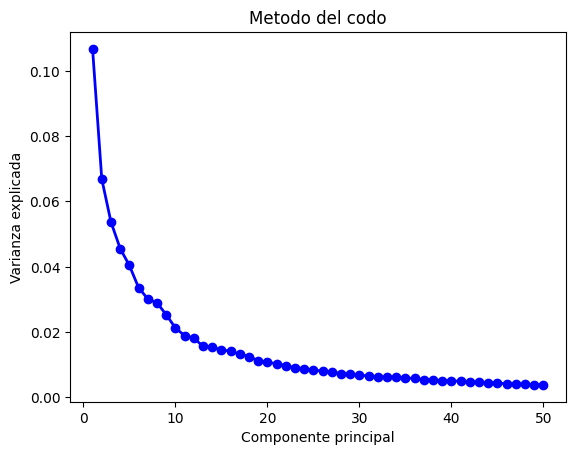

In [4]:
# Viendo cuantos componentes serian optimos con el metodo del codo
from sklearn.decomposition import PCA

pca = PCA(n_components=200)
pca.fit(matriz)

PC_values = np.arange(pca.n_components_) + 1
plt.plot(range(1,50 + 1), pca.explained_variance_ratio_[0:50], 'o-', linewidth=2, color='blue')
plt.title('Metodo del codo')
plt.xlabel('Componente principal')
plt.ylabel('Varianza explicada')
plt.show()

En este caso es un poco dificil de notar, pero con unos 7 ya empieza a ser menos efectivo, habria un segundo punto en los 10 componentes principales, pero con 7 uno ya deberia estar mas seguros.

**Sacado de:**

- https://www.statology.org/scree-plot-python/

In [8]:
# Haciendo la transformacion.

pca = PCA(n_components=7)
pca.fit(matriz)
X = pca.transform(matriz)

In [9]:
# Advertencia, esto puede tardarse un rato. 1 Minuto en mi computador.

from sklearn.cluster import KMeans

inertia = []
kmax = 60

# entrenamiento y evaluación
for i in range(1,kmax + 1):
    # modelo
    kmeans = KMeans(n_clusters=i, n_init='auto')
    nCluster = kmeans.fit(X)

    inertia.append(nCluster.inertia_)

Text(0.5, 1.0, 'K-means - Método del codo')

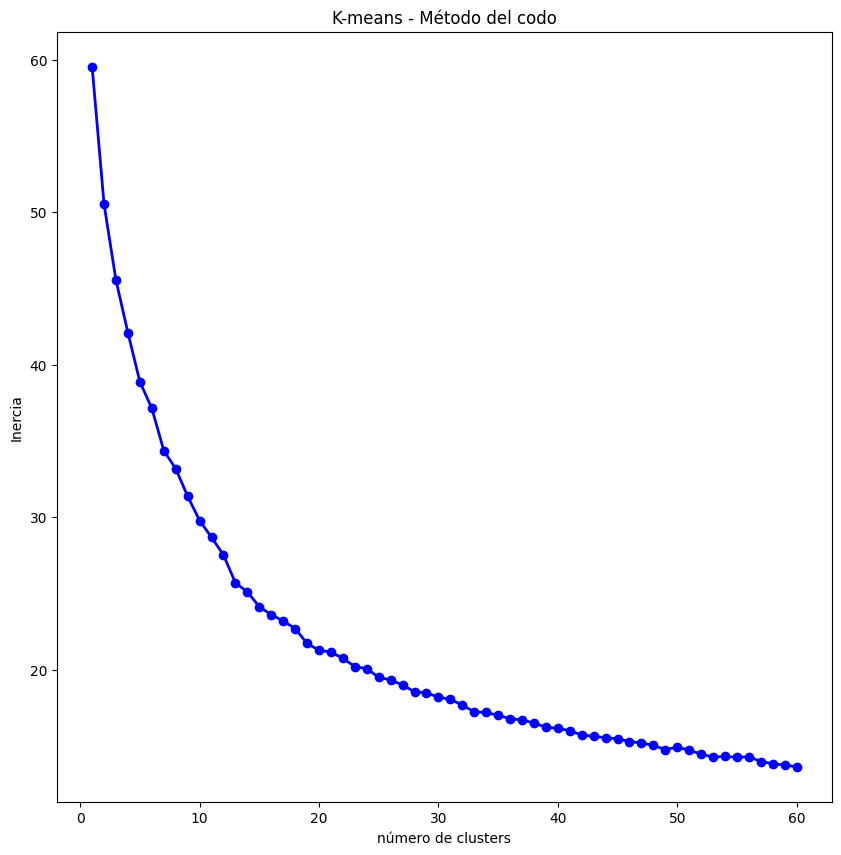

In [11]:
plt.close()
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(range(1, kmax + 1), inertia, 'o-', linewidth=2, color='blue')
ax.set_xlabel('número de clusters')
ax.set_ylabel('Inercia')
ax.set_title('K-means - Método del codo')

El metodo del codo sugiriria que lo optimo serian entre 10 y 20 clusters, para estar en el rango alto se usaran 20.

Codigo sacado de la solucion de la actividad 12